In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline


#Read in calibration images
images= os.listdir('camera_cal/')
print("Images loaded: " + str(len(images)))


Images loaded: 20


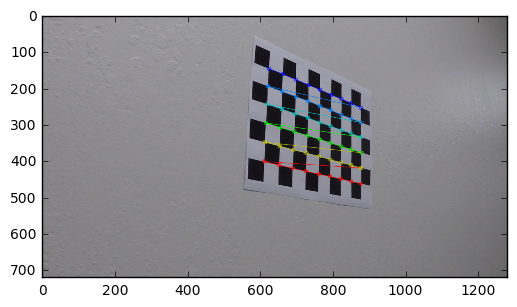

In [2]:
#Arrays to store object poinrt and image points from all the images
objpoints = []
imgpoints = []

#prepare object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

for image in images:
    #read in each image
    img = mpimg.imread('camera_cal/'+image)
    
    #Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    #If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #draw and display corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        plt.imshow(img)
    

In [4]:
#Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


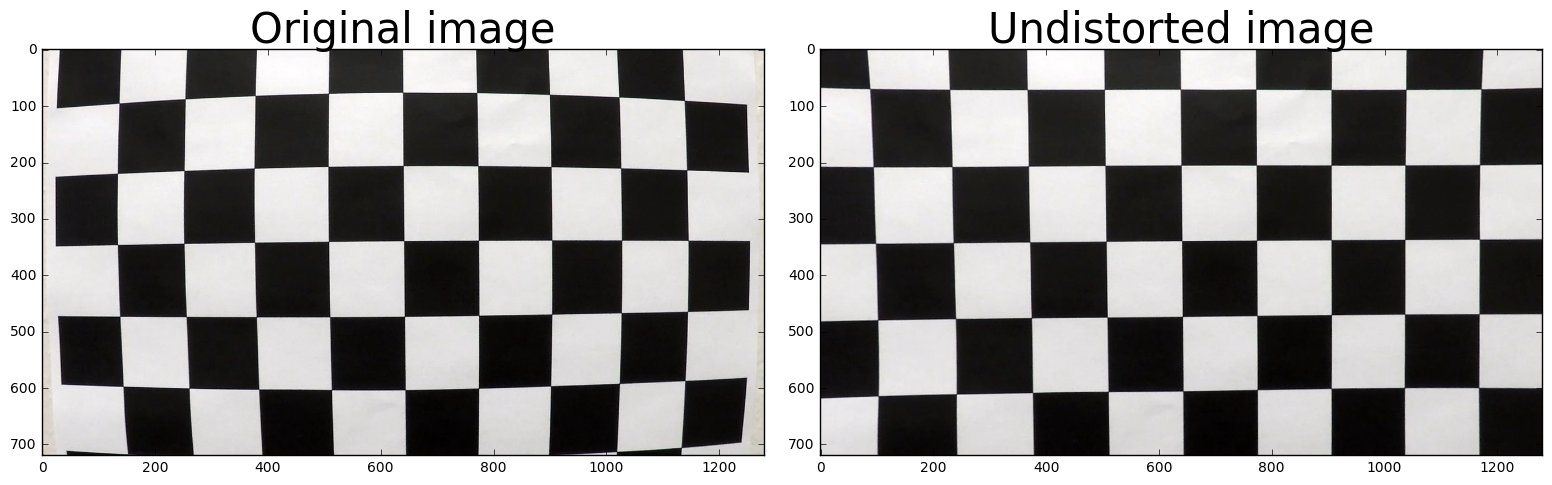

In [5]:
#undistort image
img = mpimg.imread('camera_cal/calibration1.jpg')
#img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize = 30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted image', fontsize = 30)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)

plt.show()

## Threshold

In [6]:
#Define functions thresholding

def dir_threshold (img, sobel_kernel=3, thresh = (0, np.pi/2)):
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Take the gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    #Take the absolute value of x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    #Calculate the direction of the gradient
    atan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    #Create binary output
    binary_output = np.zeros_like(atan_sobel)
    binary_output[(atan_sobel >= thresh[0]) & (atan_sobel <= thresh[1])] = 1
    return binary_output


def s_channel_threshold(img, thresh = (0,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    s_channel = hls[:,:,2]
      
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output


def r_channel_threshold(img, thresh = (0,255)):
    r_channel = img[:,:,0]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary_output

In [19]:
img = mpimg.imread('test_images/test4.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

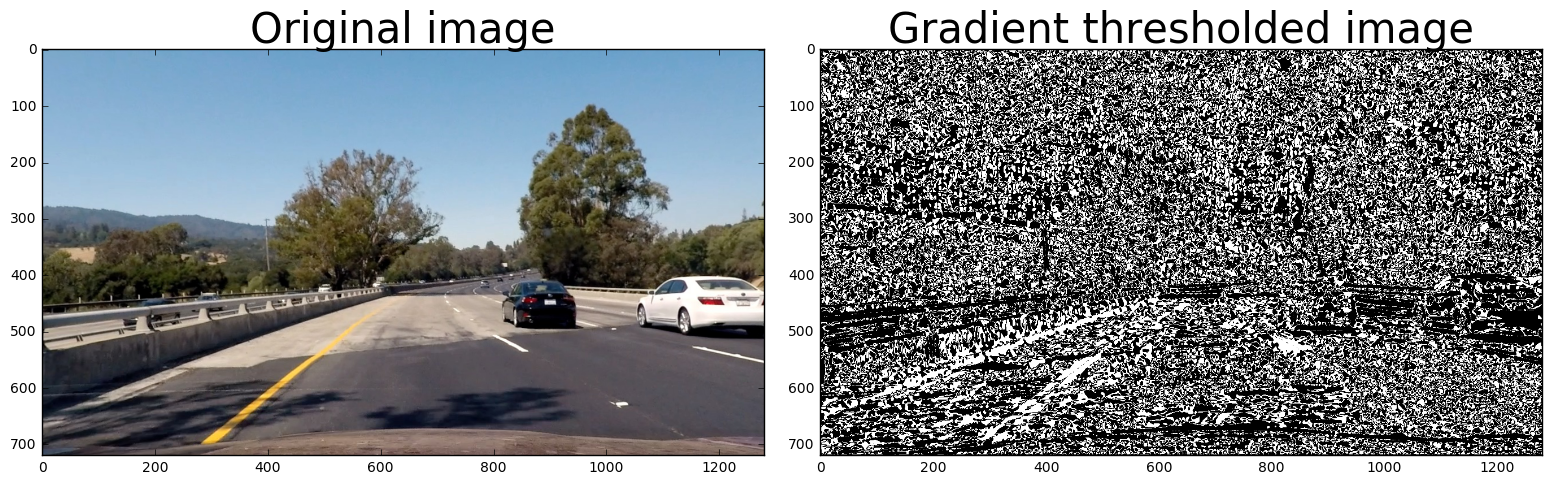

In [20]:
dir_binary = dir_threshold(undistorted, sobel_kernel = 15, thresh = (0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original image', fontsize = 30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Gradient thresholded image', fontsize = 30)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)

plt.show()

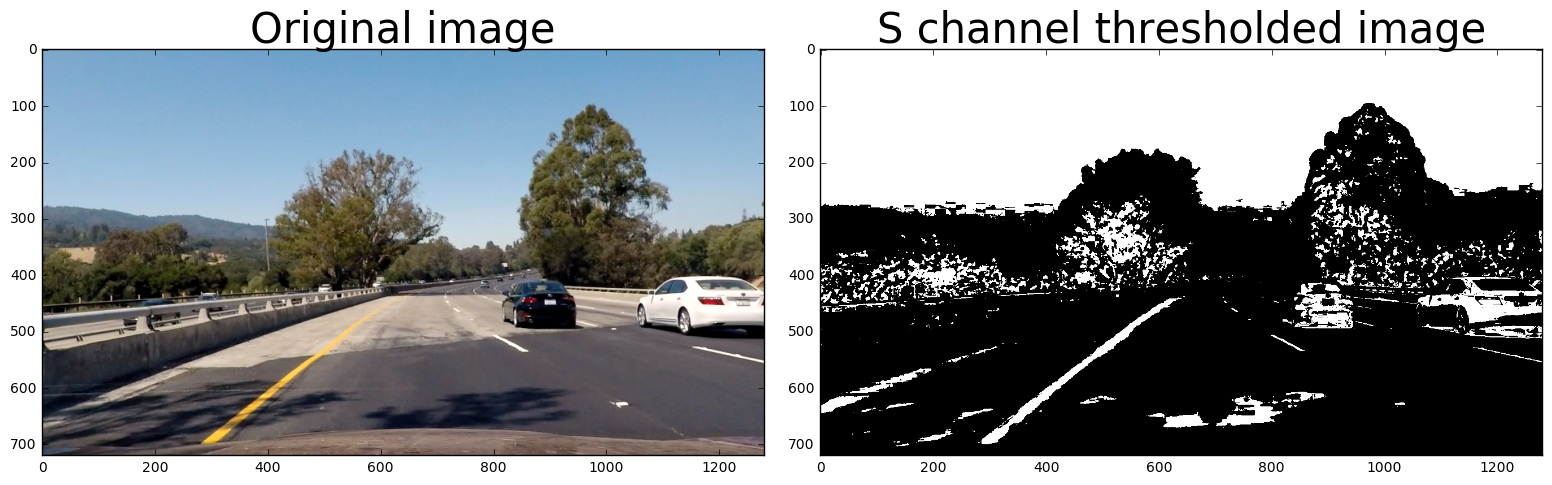

In [21]:
s_binary = s_channel_threshold(undistorted, thresh = (100, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original image', fontsize = 30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S channel thresholded image', fontsize = 30)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)

plt.show()


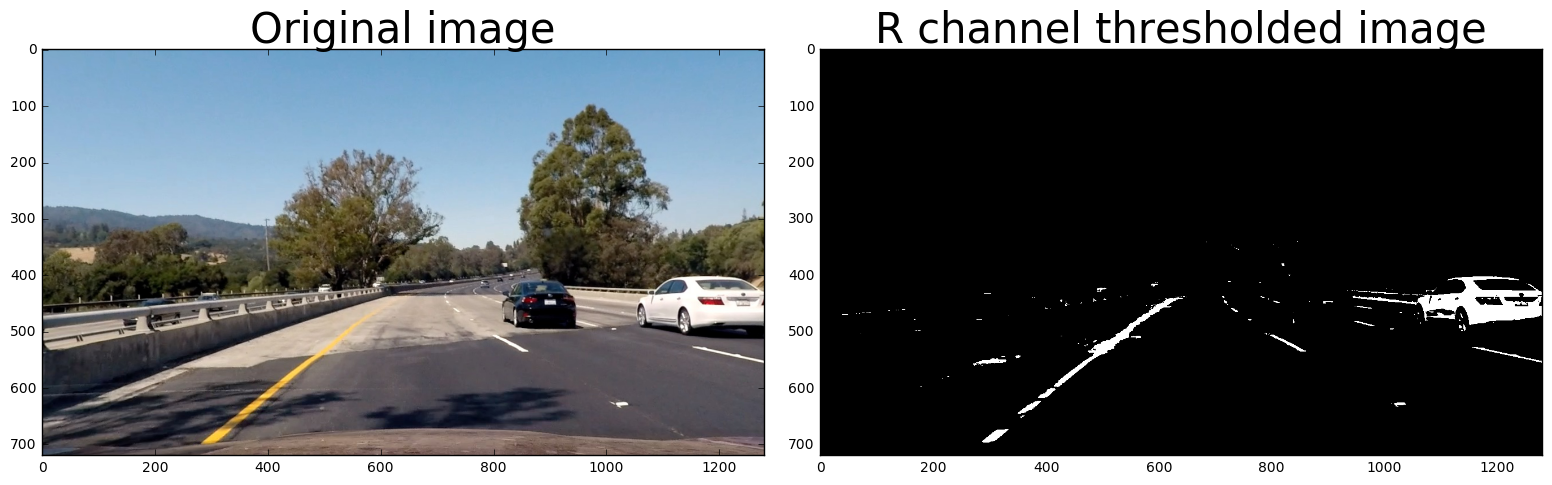

In [22]:
r_binary = r_channel_threshold(undistorted, thresh=(220, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original image', fontsize = 30)
ax2.imshow(r_binary, cmap='gray')
ax2.set_title('R channel thresholded image', fontsize = 30)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)

plt.show()

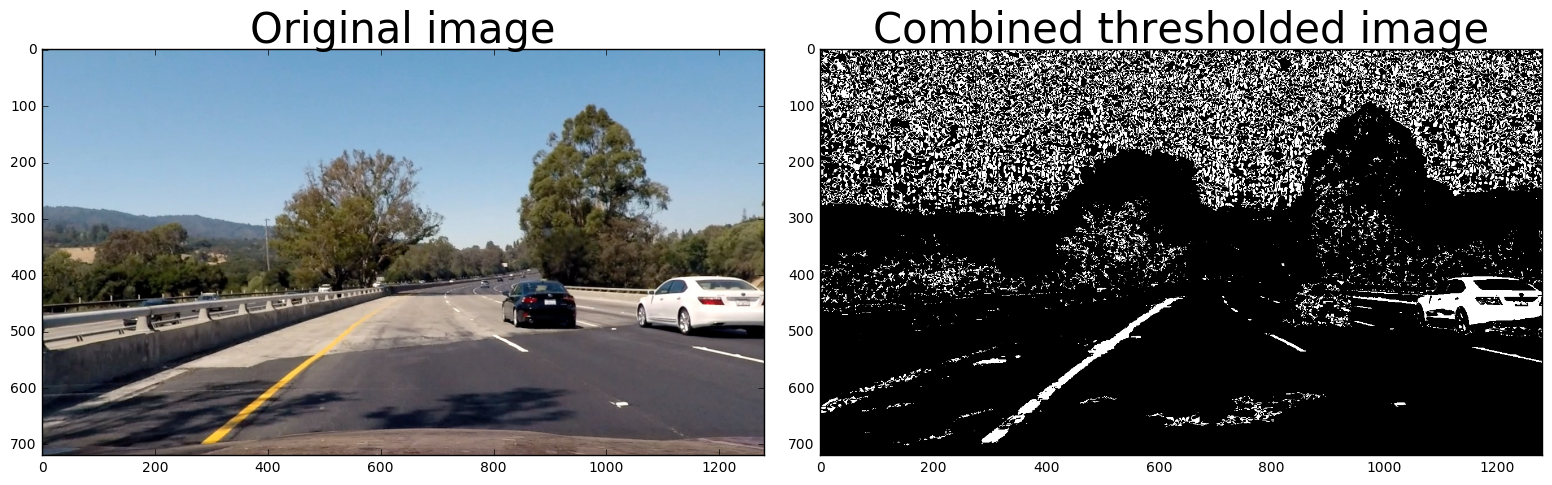

In [23]:

combined_binary = np.zeros_like(dir_binary)
combined_binary[((r_binary==1) | ((dir_binary == 1) & (s_binary == 1)))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original image', fontsize = 30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresholded image', fontsize = 30)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)

plt.show()


Execute this

In [12]:
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def apply_threshold(img):      
    dir_binary = dir_threshold (img, sobel_kernel = 15, thresh = (0.7, 1.3))
    s_binary = s_channel_threshold(img, thresh = (180, 255))
      
    r_binary = r_channel_threshold(img, thresh=(220, 255))
    
    combined_binary = np.zeros_like(dir_binary)
    #combined_binary[((s_binary == 1) | ((dir_binary == 1) & (r_binary == 1)))] = 1
    combined_binary[((r_binary==1) | ((dir_binary == 1) & (s_binary == 1)))] = 1
    return combined_binary

In [14]:
images=os.listdir("test_images/")
for i in images:
    #reading in an image
    image = mpimg.imread('test_images/'+ str(i))
    undistorted = undistort(image, mtx, dist)
    img = apply_threshold(undistorted)
    mpimg.imsave('test_images/new'+ str(i),img, cmap='gray')

## Perspective transform

In [15]:
def perspective_transform(img, src, dst):
    
    img_size= (img.shape[1], img.shape[0])

    M = cv2.getPerspectiveTransform(src,dst)

    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

def draw_lines(img, vertices):

    cv2.line(img, tuple(vertices[0]), tuple(vertices[1]), [255, 0, 0], thickness= 3)    
    cv2.line(img, tuple(vertices[1]), tuple(vertices[2]), [255, 0, 0], thickness = 3)   
    cv2.line(img, tuple(vertices[2]), tuple(vertices[3]), [255, 0, 0], thickness= 3)   
    cv2.line(img, tuple(vertices[3]), tuple(vertices[0]), [255, 0, 0], thickness = 3)     

   

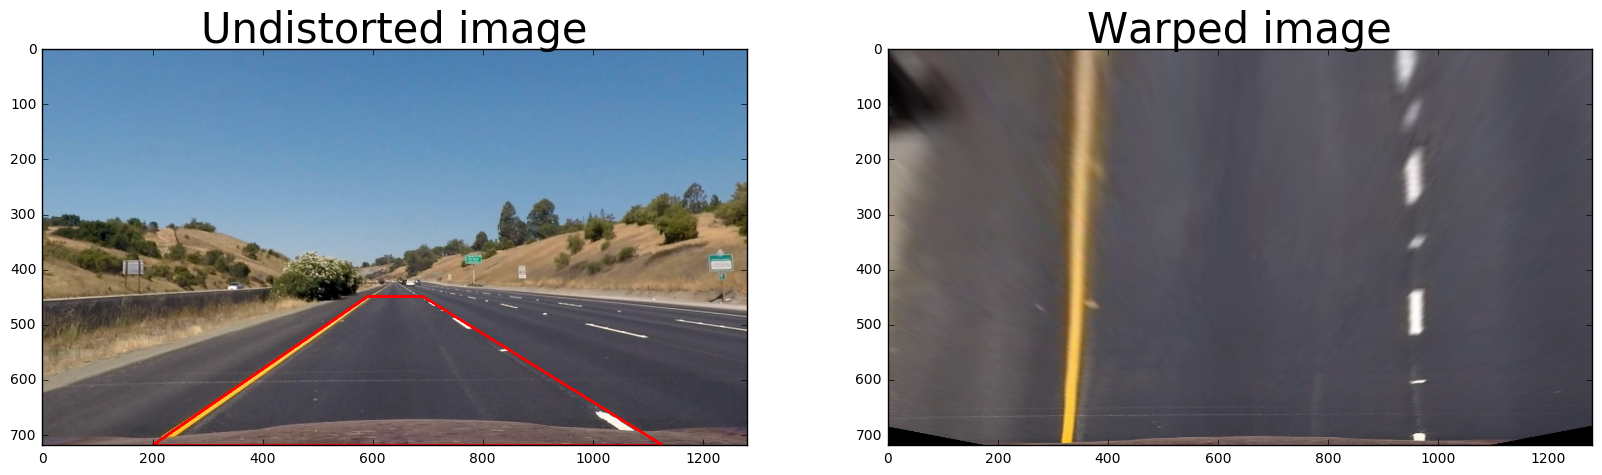

In [28]:
import math
img = mpimg.imread('test_images/straight_lines1.jpg')

undistorted = undistort(img, mtx, dist)
copy = undistort(img, mtx, dist)
#points bottom_left, bottom_right, appex_right, appex_left
src_points =np.float32([(200, img.shape[0]), (1125, img.shape[0]), (690, 450),(590, 450)])
dst_points = np.float32( [(320, 720), (980, 720), (980, 0), (320, 0)])
                   
                       
draw_lines(undistorted, src_points)

warped = perspective_transform(copy, src_points, dst_points)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.set_title('Undistorted image',fontsize = 30)
ax1.imshow(undistorted)

ax2.set_title('Warped image',fontsize = 30)
ax2.imshow(warped)

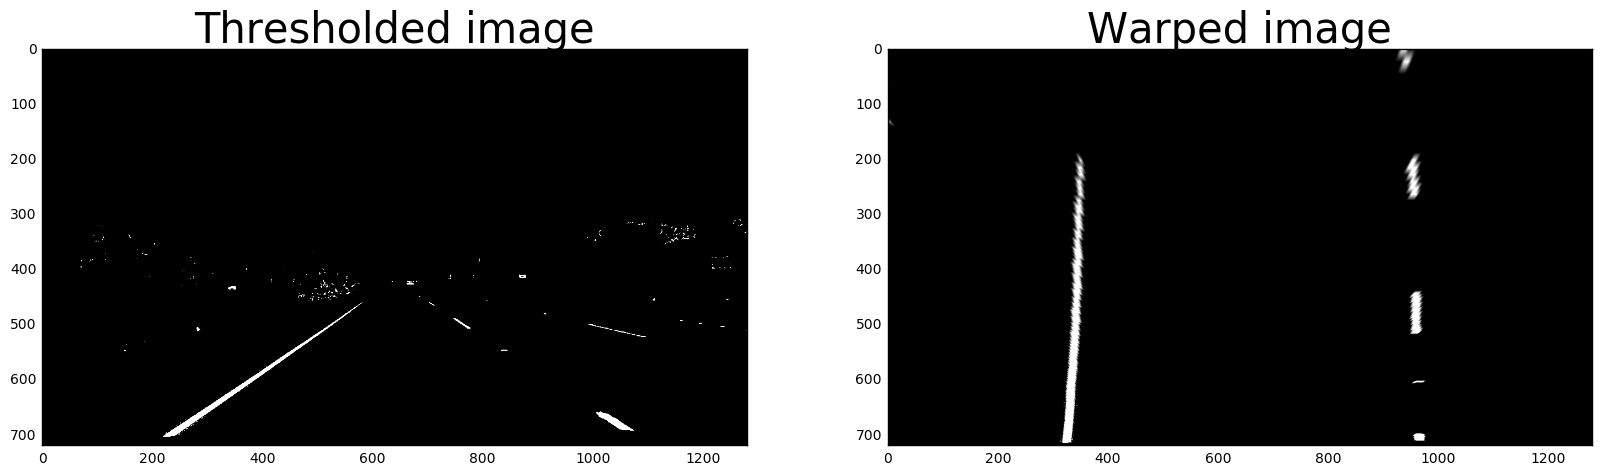

In [29]:
undistorted = undistort(img, mtx, dist)
thresh = apply_threshold(undistorted)
warped = perspective_transform(thresh, src_points, dst_points)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.set_title('Thresholded image',fontsize = 30)
ax1.imshow(thresh, cmap ='gray')

ax2.set_title('Warped image',fontsize = 30)
ax2.imshow(warped, cmap='gray')


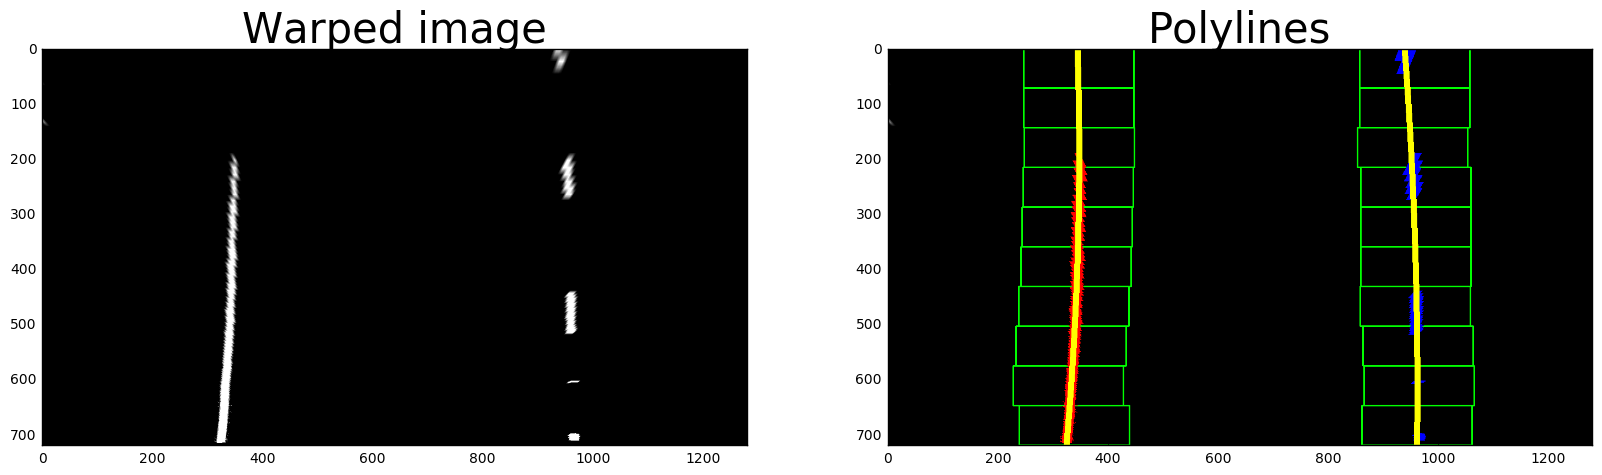

In [33]:
def get_polifyt(binary_warped):
    
    binary_warped = binary_warped*255

    # Create an image to draw on and an image to show the selection window
    out_img = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)), np.uint8)
    
        # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100


    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (255,255,0), thickness=10)
    cv2.polylines(out_img, [left], False, (255,255,0), thickness=10)
    
    return [left_fit, right_fit], out_img

fit, out_img = get_polifyt(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.set_title('Warped image',fontsize = 30)
ax1.imshow(warped, cmap ='gray')

ax2.set_title('Polylines',fontsize = 30)
ax2.imshow(out_img, cmap='jet')

#plot_images(warped, out_img, 'Warped image', "Polylines", 'gray', 'jet')


In [31]:
def drawLine(undist, warped,left_fit, right_fit, src_points, dst_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))



    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 
    newwarp = perspective_transform(color_warp, dst_points, src_points)
    # Combine the result with the original image
   
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return(result, color_warp)

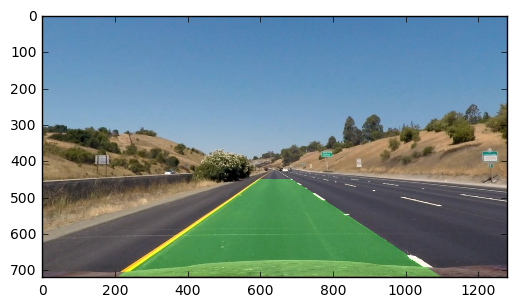

In [32]:
img_merge, img_birds = drawLine(undistorted, warped,fit[0], fit[1], src_points, dst_points)
plt.imshow(img_merge)